In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ['WANDB_MODE'] = 'dryrun'

import matplotlib.pyplot as plt
import numpy as np
import time
use_wandb = True

load_file = 'wandb/run-20200817_150014-kt17uf1a/checkpoint/1000.pt'

if 'load_file' in locals():
    print('In evaluation mode. Disabling wandb.')
    use_wandb = False
    
if use_wandb:
    import wandb
    os.environ['WANDB_NOTEBOOK_NAME'] = 'mac1_tuning.ipynb'
    wandb.init(project="transient_mac1", notes="")
    wandb.run.name = '256_256_dedicated_192_192_VaMacang_noCurrent'

In evaluation mode. Disabling wandb.


In [2]:
# this cell initializes mac1 model

from mac1 import Machine1
print(time.strftime('%H:%M:%S  ', time.localtime(time.time())))

mac1 = Machine1(n_layers=2, hidden_dim=[256,256], n_training_sample=1600, data_len=700, batchsize=100, data_interpolation_rate=5)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {mac1.model.n_layers} layers and totaling {count_parameters(mac1.model):,} trainable parameters.')

if 'load_file' in locals():
    mac1.load_pretrained(load_file)

    
loss, _ = mac1.test(mac1.train_data_torch, mac1.train_label_torch)
loss_test, _ = mac1.test(mac1.test_data_torch, mac1.test_label_torch)
rse = mac1.evaluation(mac1.test_data_torch, mac1.test_label_raw)
print("Before training:", "Train Loss:", loss, "Test Loss:", loss_test, 'Eval RSE:', np.median(rse,axis=0).mean())
if use_wandb:
    wandb.config.teacher_forcing = mac1.teacher_forcing_ratio
    wandb.config.teacher_forcing_ratio_decay = mac1.teacher_forcing_ratio_decay

    wandb.config.architecture = 'LSTM'#mac1.architecture
    wandb.config.n_layers = 2#mac1.n_layers
    wandb.config.hidden_dim = '192->192(Va, mac_ang);256->256(others)'#mac1.hidden_dim

    wandb.config.training_sample = mac1.n_training_sample
    wandb.config.data_len = mac1.data_len
    wandb.config.apply_mac_ang_filter = True#mac1.apply_mac_ang_filter
    wandb.config.angle_setting = 'Polar, unwarped'

    wandb.log({"Epoch": mac1.trained_epochs-1, "Train Loss": loss, "Test Loss": loss_test, 'Eval RSE':np.median(rse,axis=0).mean()})

11:45:19  
GPU is available. Deploying GPU.
The model has 2 layers and totaling 1,253,767 trainable parameters.
Parameters loaded in.
Before training: train eval RSE = 4.618e-02, test eval RSE = 4.917e-02
Before training: Train Loss: 0.002292827673954889 Test Loss: 0.003999487264081836 Eval RSE: 0.04916558362536294


Training process took 0.0 mins.
GPU memory stats: Max Reserved 682 Mb, Max Allocated 610 Mb
Denormalized: train Loss = 2.350e-04, test Loss = 2.759e-04
Relative SE after de-normalization: train 3.843e-02, test 4.027e-02

Detailed RRMSE: [0.04282761 0.00830684 0.01609758 0.0919898  0.12506336 0.
 0.05987389]
Average of RRMSE: 0.04916558362536294


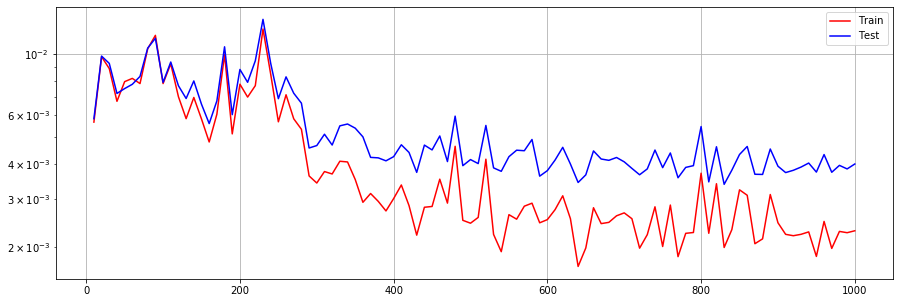

In [3]:
# this cell trains the model

#### %matplotlib inline
import torch

start_time = time.time()
trained_epochs = mac1.trained_epochs
train_for_epochs = 100 if use_wandb else 0
min_eval_rse = np.inf
save_to_file = False
for i in range(trained_epochs, trained_epochs+train_for_epochs):
    mac1.train_for_one_epoch()

    if i % 10 == 0:
        loss, _ = mac1.test(mac1.train_data_torch, mac1.train_label_torch)
        loss_test, _ = mac1.test(mac1.test_data_torch, mac1.test_label_torch)
        mac1.loss_curve.append([i, loss, loss_test])
        
        rse_train = mac1.evaluation(mac1.train_data_torch, mac1.train_label_raw)
        rse_test = mac1.evaluation(mac1.test_data_torch, mac1.test_label_raw)
        
        if use_wandb:
            if np.median(rse_test,axis=0).mean() < min_eval_rse:
                min_eval_rse = np.median(rse_test,axis=0).mean()
                save_to_file = True
            
            wandb.log({"Epoch": i, "Train Loss": loss, "Test Loss": loss_test, 'Eval RSE in training':np.median(rse_train,axis=0).mean(), 'Eval RSE':np.median(rse_test,axis=0).mean()})

    if i % 10 == 0:
        ETA = (time.time() - start_time) / (i - trained_epochs + 1) * (trained_epochs+train_for_epochs-i) / 60
        print(time.strftime('%H:%M:%S  ', time.localtime(time.time())), end="")
        print('ETA:{:.1f}mins '.format(ETA), end="")
        print('Epoch {}: train Loss = {:.3e}, test Loss = {:.3e}, eval = {:.3e}'.format(i, loss, loss_test, np.median(rse_test,axis=0).mean()))

    if use_wandb and i % 100 == 0:
        save_to_file = True
        
    if save_to_file and i >= 600:
        save_to_file = False
        
        if not os.path.exists(os.path.join(wandb.run.dir, 'checkpoint')):
            os.makedirs(os.path.join(wandb.run.dir, 'checkpoint'))

        torch.save({'model_state_dict': mac1.model.state_dict(), 
                    'optimizer_state_dict': mac1.optimizer.state_dict(), 
                    'epoch': i,
                    'loss_curve':mac1.loss_curve
                    },
                   '{:s}/{:d}.pt'.format(os.path.join(wandb.run.dir, 'checkpoint'), i))
        
print('Training process took {:.1f} mins.'.format((time.time()-start_time)/60))

if len(mac1.loss_curve) > 0:
    plt.figure(0, figsize=(15, 5))
    plt.plot(np.array(mac1.loss_curve)[:, 0], np.array(mac1.loss_curve)[:, 1], 'r', label="Train")
    plt.plot(np.array(mac1.loss_curve)[:, 0], np.array(mac1.loss_curve)[:, 2], 'b', label="Test")
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
#     plt.show()

if mac1.use_GPU:
    print('GPU memory stats: Max Reserved {:.0f} Mb, Max Allocated {:.0f} Mb'.format(
        torch.cuda.max_memory_reserved(0)/1024/1024, torch.cuda.max_memory_allocated(0)/1024/1024))

_, prediction_train_raw = mac1.test(mac1.train_data_torch, mac1.train_label_torch)
_, prediction_test_raw = mac1.test(mac1.test_data_torch, mac1.test_label_torch)

prediction_train = prediction_train_raw * mac1.label_std + mac1.label_mean
prediction_test = prediction_test_raw * mac1.label_std + mac1.label_mean
    
mse_train = np.mean(np.mean(np.square(prediction_train - mac1.train_label_raw), axis=1), axis=0)
mse_test = np.mean(np.mean(np.square(prediction_test - mac1.test_label_raw), axis=1), axis=0)

print('Denormalized: train Loss = %.3e, test Loss = %.3e' % (mse_train.mean(), mse_test.mean()))

se_train = np.linalg.norm(prediction_train - mac1.train_label_raw, 2, axis=0) / (np.linalg.norm(mac1.train_label_raw-mac1.train_label_raw.mean(axis=0), 2, axis=0) + 1e-5)
se_test = np.linalg.norm(prediction_test - mac1.test_label_raw, 2, axis=0) / (np.linalg.norm(mac1.test_label_raw-mac1.test_label_raw.mean(axis=0), 2, axis=0) + 1e-5)
rse_train = np.median(se_train, axis=0)
rse_test = np.median(se_test, axis=0)
print('Relative SE after de-normalization: train {:.3e}, test {:.3e}'.format(rse_train.mean(), rse_test.mean()))

### Evaluation
rse = mac1.evaluation(mac1.test_data_torch, mac1.test_label_raw)
print()
print('Detailed RRMSE:', np.median(rse,axis=0))
print('Average of RRMSE:', np.median(rse,axis=0).mean())

if use_wandb:
    wandb.log({"Training Time": (time.time()-start_time)/60})
    wandb.log({"Train Relative SE": rse_train.mean()})
    wandb.log({"Test Relative SE": rse_test.mean()})
    wandb.log({"Detailed Relative SE": rse_train})
    wandb.log({"Detailed Relative SE": rse_test})
    
    wandb.log({"Prediction RSE": np.median(rse,axis=0)})
    wandb.log({"Overall": np.median(rse,axis=0).mean()})
    wandb.log({"Min RRMSE": min_eval_rse})

In [4]:
# torch.save({'model_state_dict':mac1.model.state_dict(), 'optimizer_state_dict': mac1.optimizer.state_dict(), 'epoch': mac1.trained_epochs, 'loss_curve':mac1.loss_curve}, '6_23_2020.pt')

# Save model to wandb
# if use_wandb:
#     torch.save({'model_state_dict':mac1.model.state_dict(), 
#                 'optimizer_state_dict': mac1.optimizer.state_dict(), 
#                 'epoch': mac1.trained_epochs, 
#                 'loss_curve':mac1.loss_curve
#                }, 
#                os.path.join(wandb.run.dir, 'model.pt'))
#     torch.save(model.state_dict(), os.path.join(wandb.run.dir, 'model.pt'))

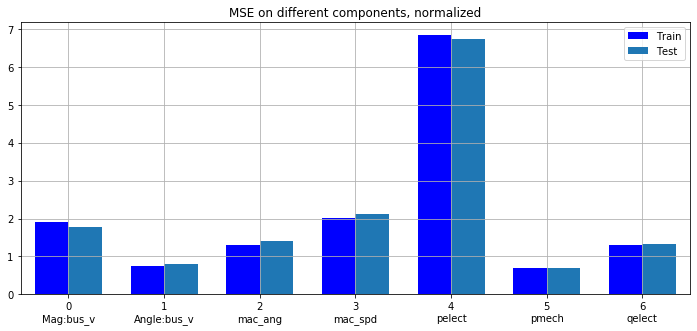

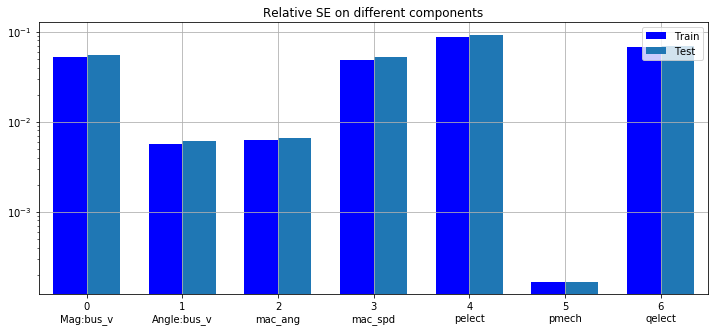

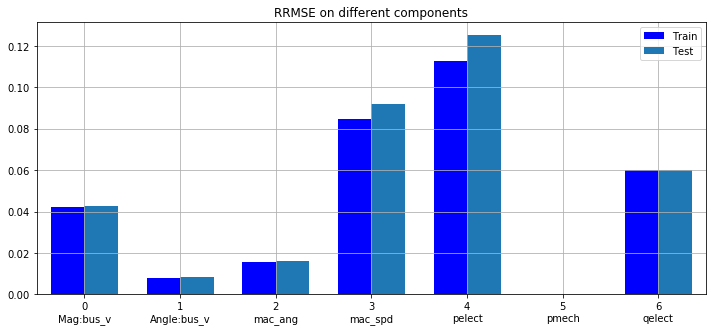

In [5]:
c = ['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'orange', 'b', 'b', 'b']
c2 = ['C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'darkorange', 'C0', 'C0', 'C0']
x = np.arange(7)
# xticks=('0\nR:bus_v', '1\nI:bus_v', '2\nR:cur1', '3\nR:cur2', '4\nR:cur3', '5\nR:cur4', '6\nR:cur5', '7\nI:cur1', '8\nI:cur2', '9\nI:cur3', \
#                        '10\nI:cur4', '11\nI:cur5', '12\nbus_freq', '13\nmac_ang', '14\nmac_spd', '15\npelect', '16\npmech', '17\nqelect')
xticks = ('0\nMag:bus_v', '1\nAngle:bus_v', '2\nmac_ang', '3\nmac_spd', '4\npelect', '5\npmech', '6\nqelect')
width = 0.35

# plt.figure(1,figsize=(15,7))
# plt.bar(range(8), data_std, color=c)
# plt.xticks(range(8), ('0\nR:bus_v', '1\nI:bus_v', '2\nR:cur1', '3\nR:cur2', '4\nR:cur3', '5\nR:cur4', '6\nR:cur5', '7\nI:cur1', '8\nI:cur2', '9\nI:cur3', \
#                        '10\nI:cur4', '11\nI:cur5', '12\nbus_freq', '13\nmac_ang', '14\nmac_spd', '15\npelect', '16\npmech', '17\nqelect'))
# plt.grid(True)
# plt.xlim([-0.5,17.5])
# # plt.ylim([0,0.001])
# plt.title('Standard Deviations on different components')

mse_train_n = np.mean(np.mean(np.square(prediction_train_raw - mac1.train_label_raw), axis=1), axis=0)
mse_test_n = np.mean(np.mean(np.square(prediction_test_raw - mac1.test_label_raw), axis=1), axis=0)

plt.figure(2, figsize=(12, 5))
plt.bar(x-width/2, mse_train_n, width, label='Train', color=c)
plt.bar(x+width/2, mse_test_n, width, label='Test', color=c2)
plt.xticks(x, xticks)
plt.grid(True)
plt.xlim([-0.5, 6.5])
plt.legend()
# plt.ylim([0,1e-6])
plt.title('MSE on different components, normalized')


plt.figure(3, figsize=(12, 5))
plt.bar(x-width/2, rse_train, width, label='Train', color=c)
plt.bar(x+width/2, rse_test, width, label='Test', color=c2)
plt.xticks(x, xticks)
plt.grid(True)
plt.xlim([-0.5, 6.5])
plt.legend()
plt.yscale('log')
# plt.ylim([0,1e-1])
plt.title('Relative SE on different components')


eval_rse_train = mac1.evaluation(mac1.train_data_torch, mac1.train_label_raw)
eval_rse_test = mac1.evaluation(mac1.test_data_torch, mac1.test_label_raw)
eval_rse_train = np.median(eval_rse_train,axis=0)
eval_rse_test = np.median(eval_rse_test,axis=0)
plt.figure(4, figsize=(12, 5))
plt.bar(x-width/2, eval_rse_train, width, label='Train', color=c)
plt.bar(x+width/2, eval_rse_test, width, label='Test', color=c2)
plt.xticks(x, xticks)
plt.grid(True)
plt.xlim([-0.5, 6.5])
plt.legend()
# plt.yscale('log')
# plt.ylim([0,1e-1])
plt.title('RRMSE on different components')
plt.show()

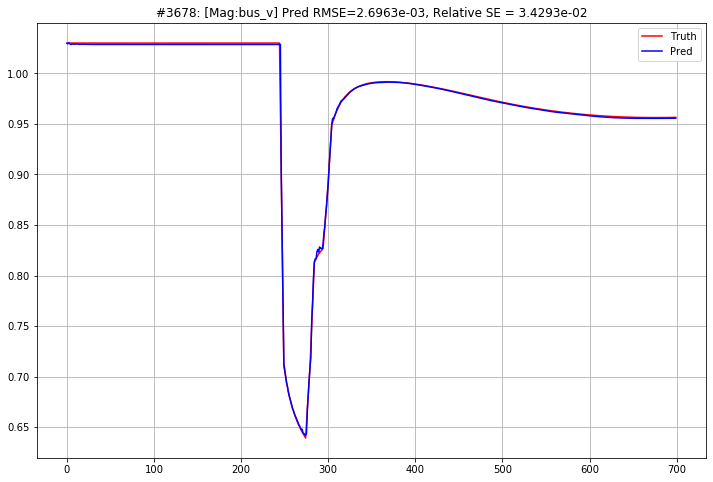

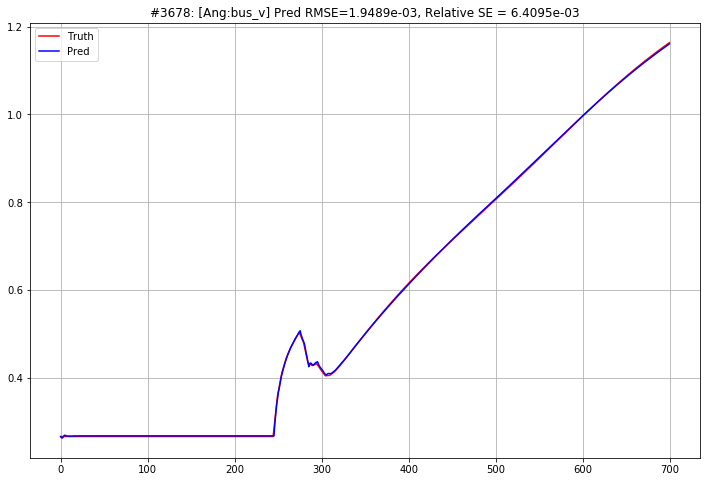

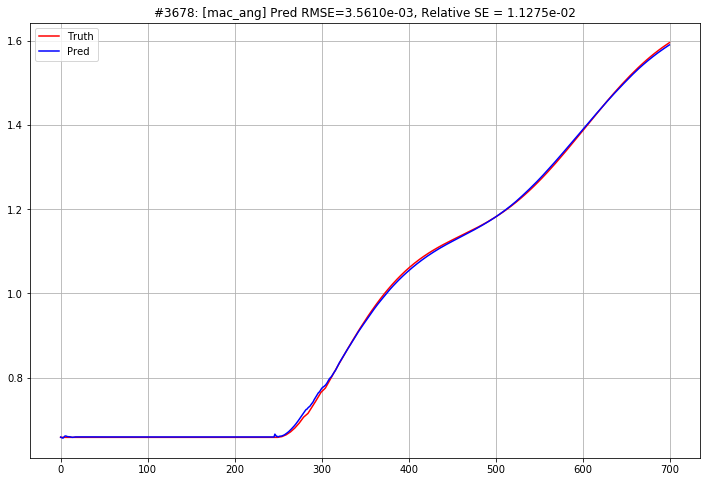

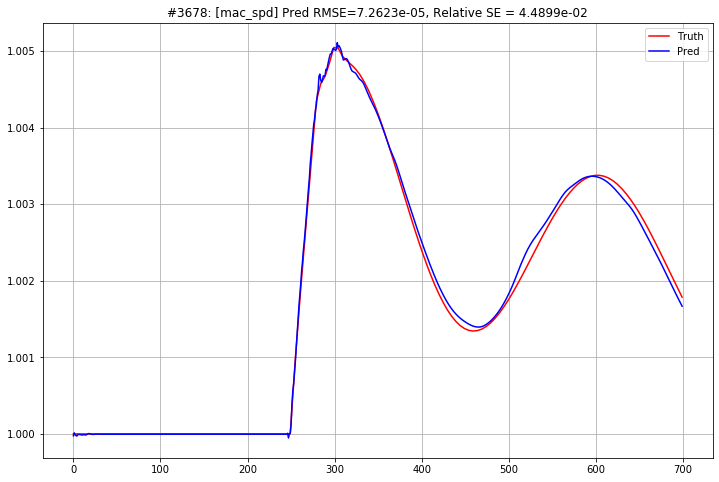

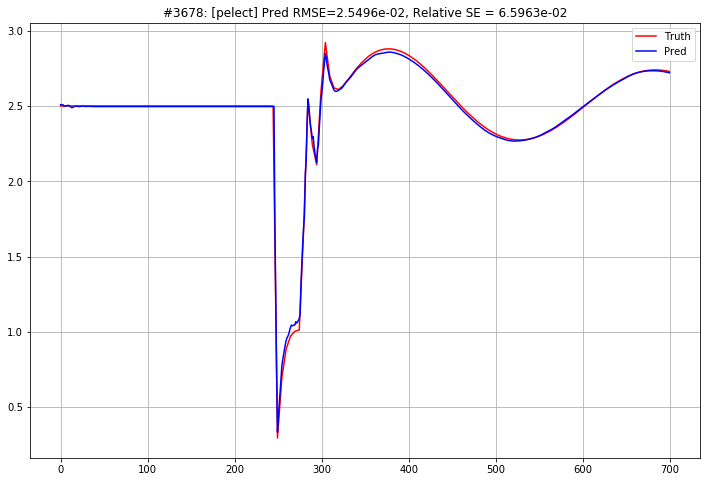

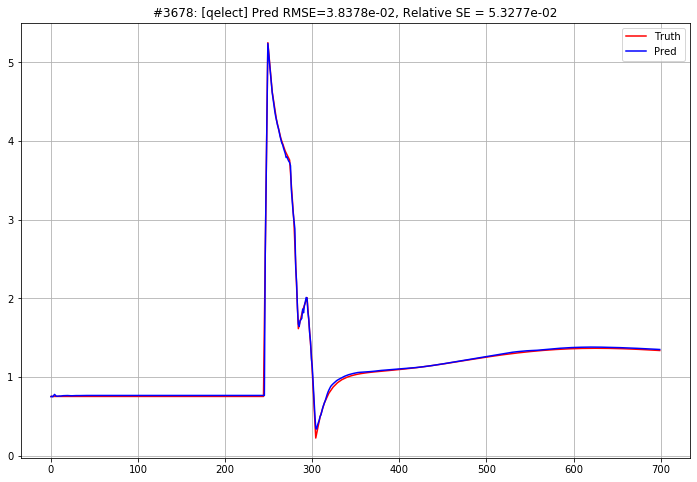

In [57]:
# this cell tests the model

# entry = np.floor(np.random.uniform(low=0, high=1600, size=(1, 1))).astype(int).reshape(-1) # randomly pick a training sample for evaluation
# entry = np.floor(np.random.uniform(low=4800, high=5200, size=(1, 1))).astype(int).reshape(-1) # randomly pick a testing sample for evaluation

entry=[3678]
# entry =[2108]  % contigency at Line 5
# entry=[4880]  % another contigency at Line 5
# entry = [4800]
# entry = mac1.sample_idx[entry]
t_max = 700 # predicts for 700 steps

quantities = [0,1,2,3,4,5,6]  # in data indices
quantities_transform = [0, 1, 2, 3, 4, 5, 6]  # transform data indices to label indices
quantites_names = ['Mag:bus_v', 'Ang:bus_v', 'mac_ang', 'mac_spd', 'pelect', 'pmech', 'qelect']

mac1.model.eval()
for i in entry:    
    filename = mac1.data['filename'][0][i][0]
    if (filename.find('a5a') > -1 or filename.find('a5.') > -1):
        print('WARRNING: {:s} contains a line-5 fault.'.format(data['filename'][0][i][0]))

    # tmp_test_data: [t_max, 9]
    # tmp_test_label: [t_max, 9]
    tmp_test_data, tmp_test_label = mac1.extract_data(i, t_max, data_interpolation_rate=5, clip=50)
    
    tmp_test_data_torch = (tmp_test_data - mac1.data_mean) / mac1.data_std
    tmp_test_data_torch = torch.from_numpy(tmp_test_data_torch).to(mac1.device).float()

    output_data = np.zeros_like(tmp_test_label)
    t_start = 0
    rnn_states = mac1.model.initial_states()
    input_data_torch = tmp_test_data_torch[t_start, :].reshape(1,1,-1)
    for t in range(t_start, t_max):
        output_data_torch, rnn_states = mac1.model(input_data_torch, rnn_states)
        output_data[t,:] = output_data_torch.data.cpu().numpy()
        if t < t_max-1:
            input_data_torch = torch.cat((output_data_torch[0,0,0:7],
                                          tmp_test_data_torch[t+1,7:9])
                                        ).reshape(1,1,-1)

    # de-normalization for plotting and computing RRMSE
    output_data = output_data * mac1.label_std + mac1.label_mean

    # Plotting predicted variables in mac1
    for q in range(7):
        if quantites_names[q] == 'pmech':
            continue

        truth_curve = tmp_test_label[:t_max, quantities_transform[q]]
        pred_curve = output_data[:t_max, quantities_transform[q]]

        # use computed pelect, qelect
#         if q==4 or q==6:
#             computed_tpsi = 1 / 1.025
#             computed_chg = 0
#             computed_y = 1 / (0 + 0.0181j)
#             computed_V1 = tmp_test_data[1:700, 7] * np.exp(1j * tmp_test_data[1:700, 8]) # from bus: bus2 
#             computed_V2 = output_data[:699, 0] * np.exp(1j * output_data[:699, 1]) #   to bus: bus53
#             curFrom = -computed_tpsi*(computed_y*(computed_tpsi*computed_V1-computed_V2) + computed_chg*computed_V1) # current injection at from_bus
#             curTo = computed_y*(computed_V2 - computed_tpsi*computed_V1) + computed_chg*computed_V2;
#             sp = computed_V2 * np.conj(curTo)
#             if q == 4:
#                 pred_curve = np.real(sp)
#             else:
#                 pred_curve = np.imag(sp)
#             pred_curve = np.append(pred_curve, pred_curve[-1])
                
        plt.figure(q, figsize=(12, 8))
        plt.plot(range(t_max), truth_curve, 'r', label='Truth')
        plt.plot(range(t_max), pred_curve, 'b', label='Pred')
        plt.legend()
        plt.grid(True)

        rmse = np.sqrt(np.mean(np.square(truth_curve - pred_curve)))
        rse = np.linalg.norm(truth_curve - pred_curve, 2) / (np.linalg.norm(truth_curve-truth_curve.mean(), 2) + 1e-6)
        plt.title('#{:d}: [{:s}] Pred RMSE={:.4e}, Relative SE = {:.4e}'.format(i, quantites_names[q], rmse, rse))
        
        

# plt.show()

# sio.savemat('example1.mat',{'label':tmp_test_label, 'data':output_data})